ECG Signal Processing Tool

Current data path: D:\Academic
Available .dat files: ['test07_00s.dat', 'test16_00w.dat', 'test26_45j.dat']

Default files to process: ['test07_00s.dat', 'test16_00w.dat', 'test26_45j.dat']

Files to process: ['test07_00s.dat', 'test16_00w.dat', 'test26_45j.dat']
Loaded test07_00s.dat: 4000 samples, 4 channels
Duration: 8.00 seconds

Processing test07_00s.dat (Standing)
Loaded test16_00w.dat: 4000 samples, 4 channels
Duration: 8.00 seconds

Processing test16_00w.dat (Walking)
Loaded test26_45j.dat: 4000 samples, 4 channels
Duration: 8.00 seconds

Processing test26_45j.dat (Jumping)

FFT ANALYSIS


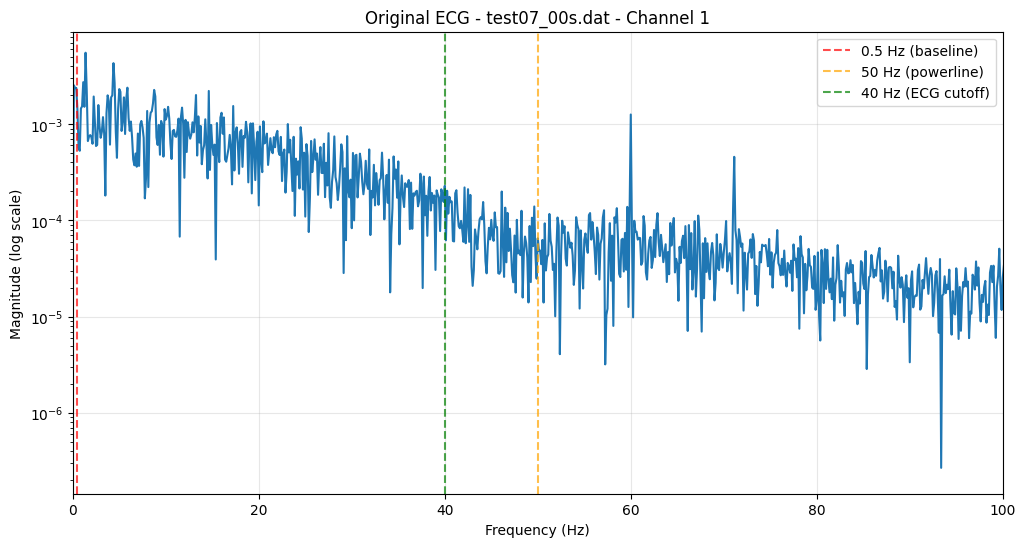

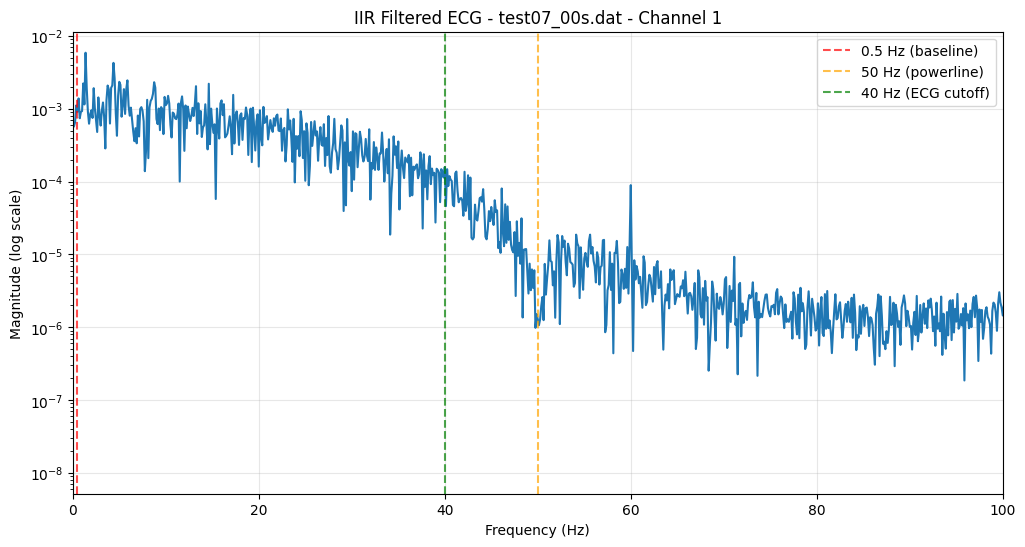

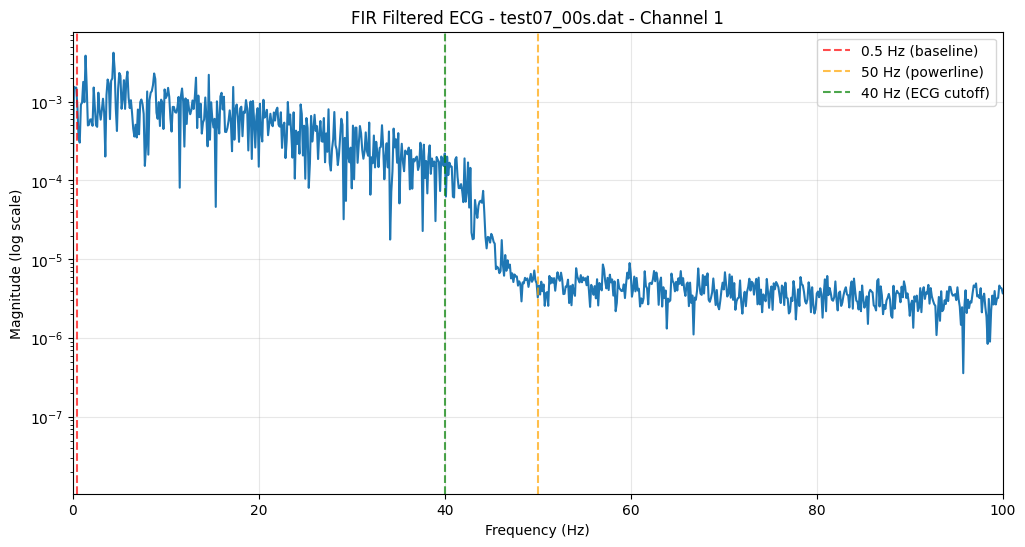


Analyzing filter parameters for test07_00s.dat...


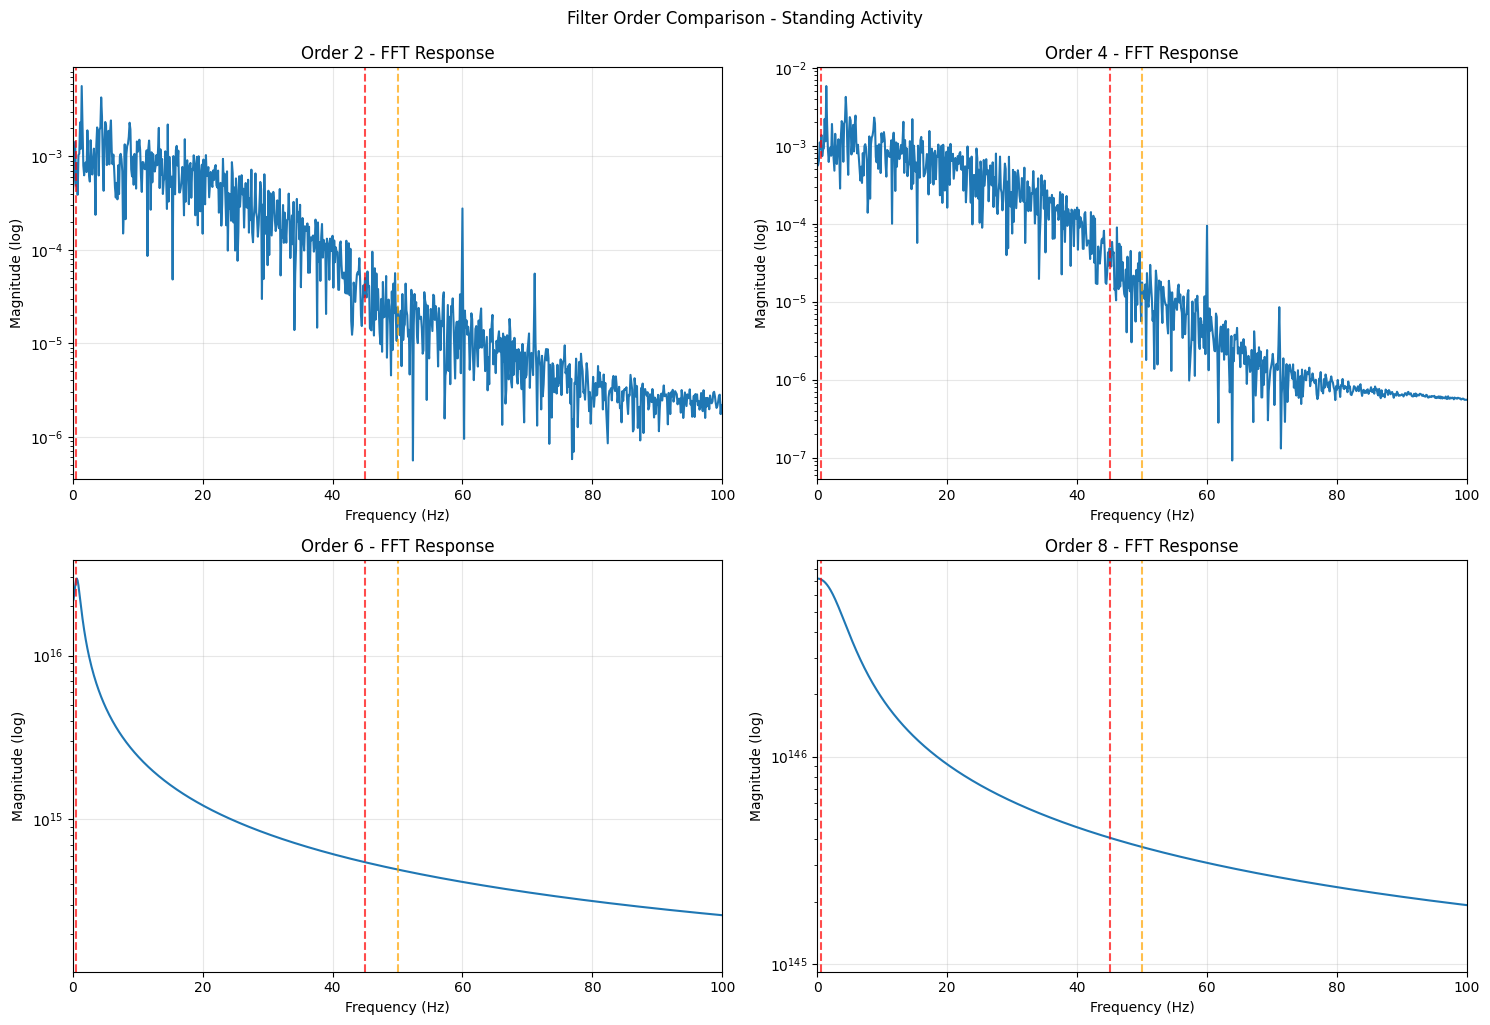

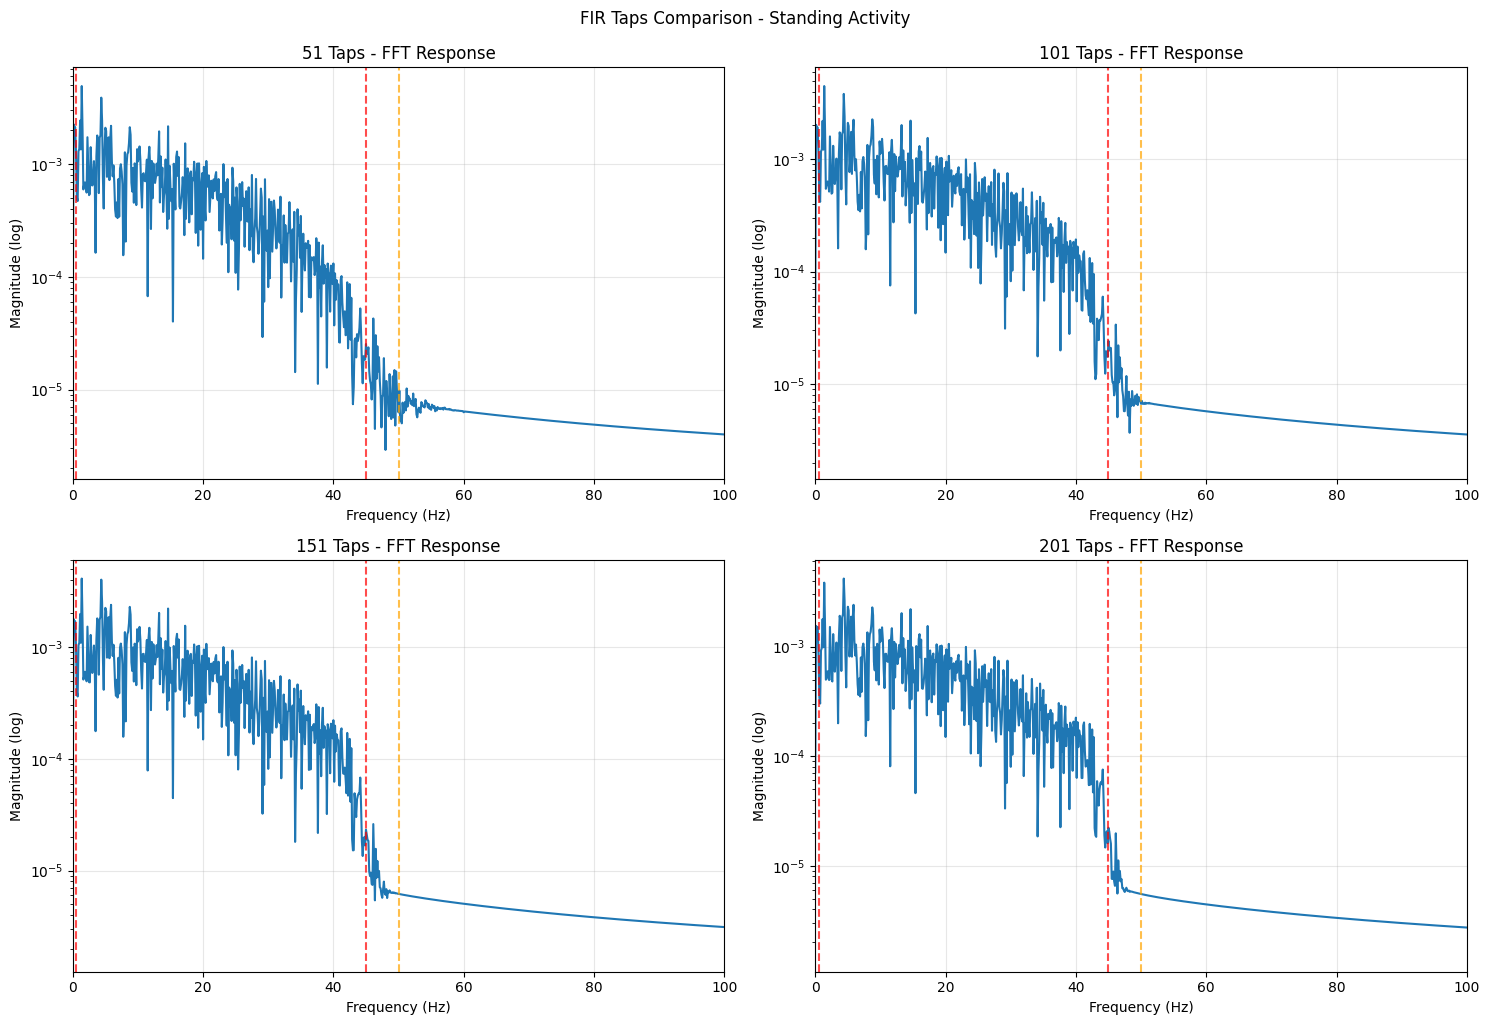


Analyzing filter parameters for test16_00w.dat...


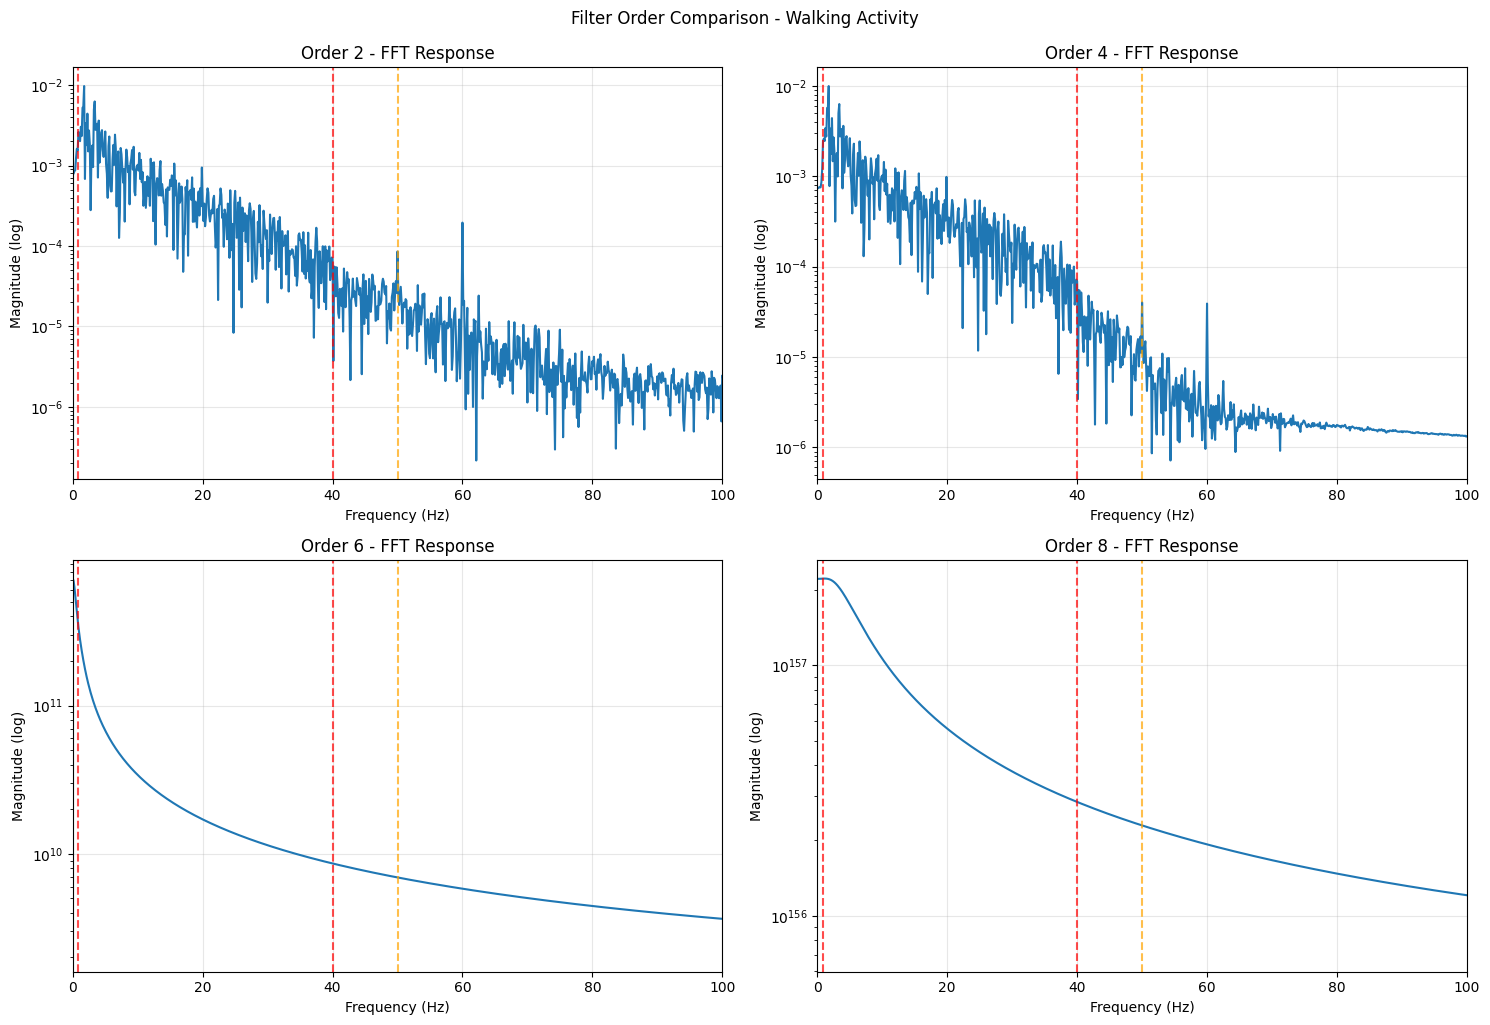

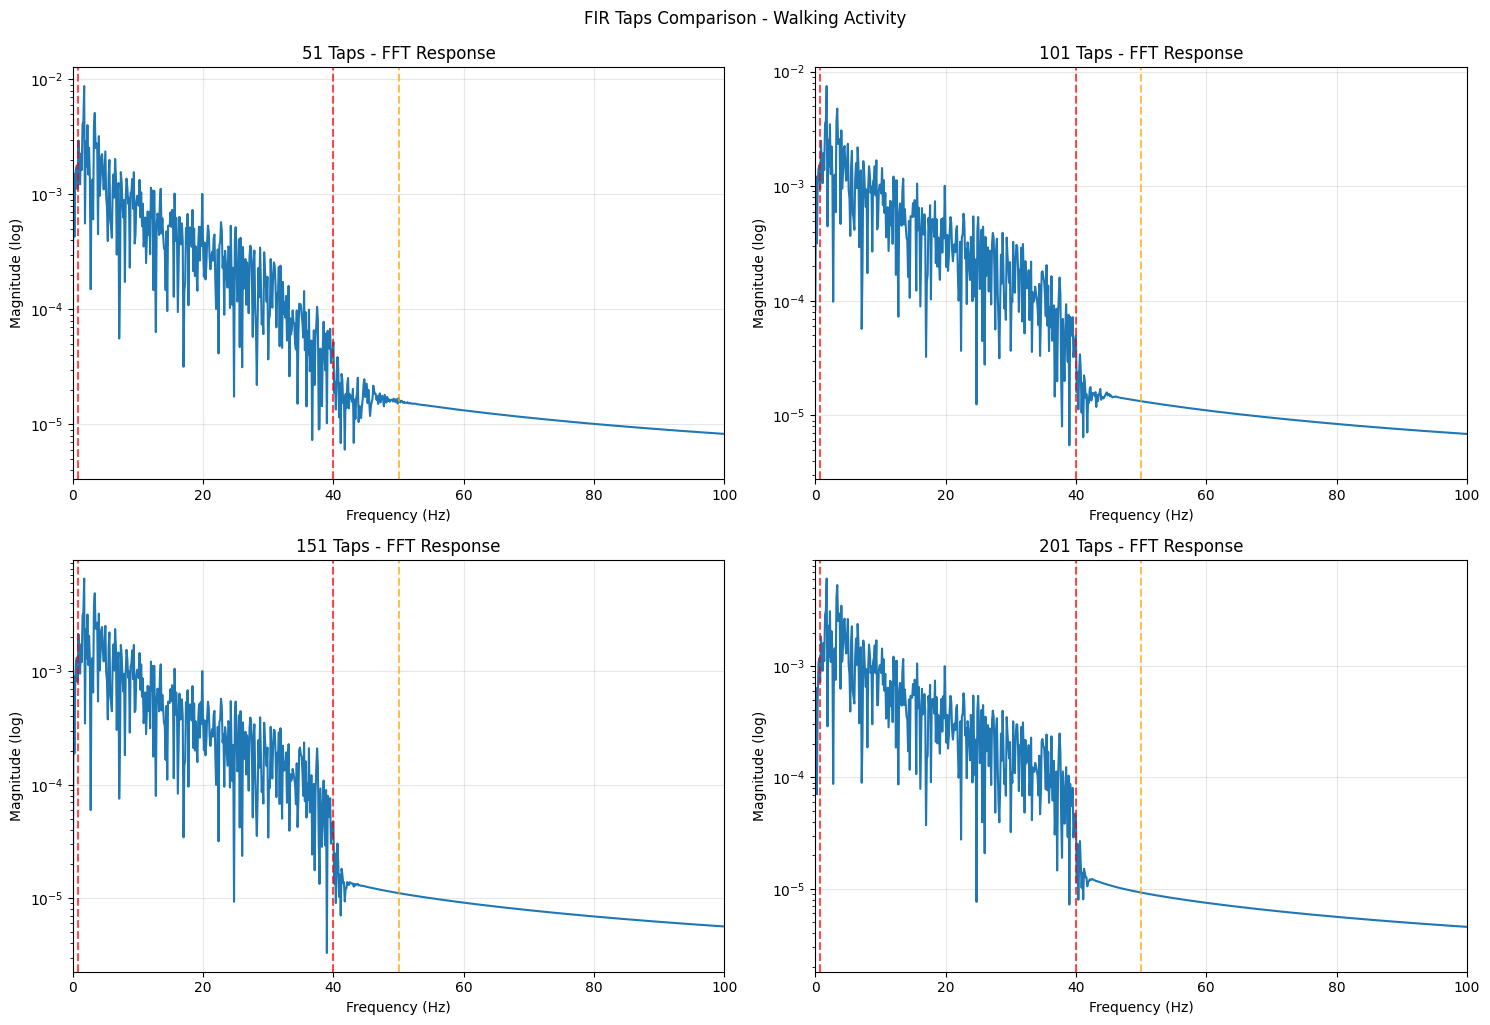


Analyzing filter parameters for test26_45j.dat...


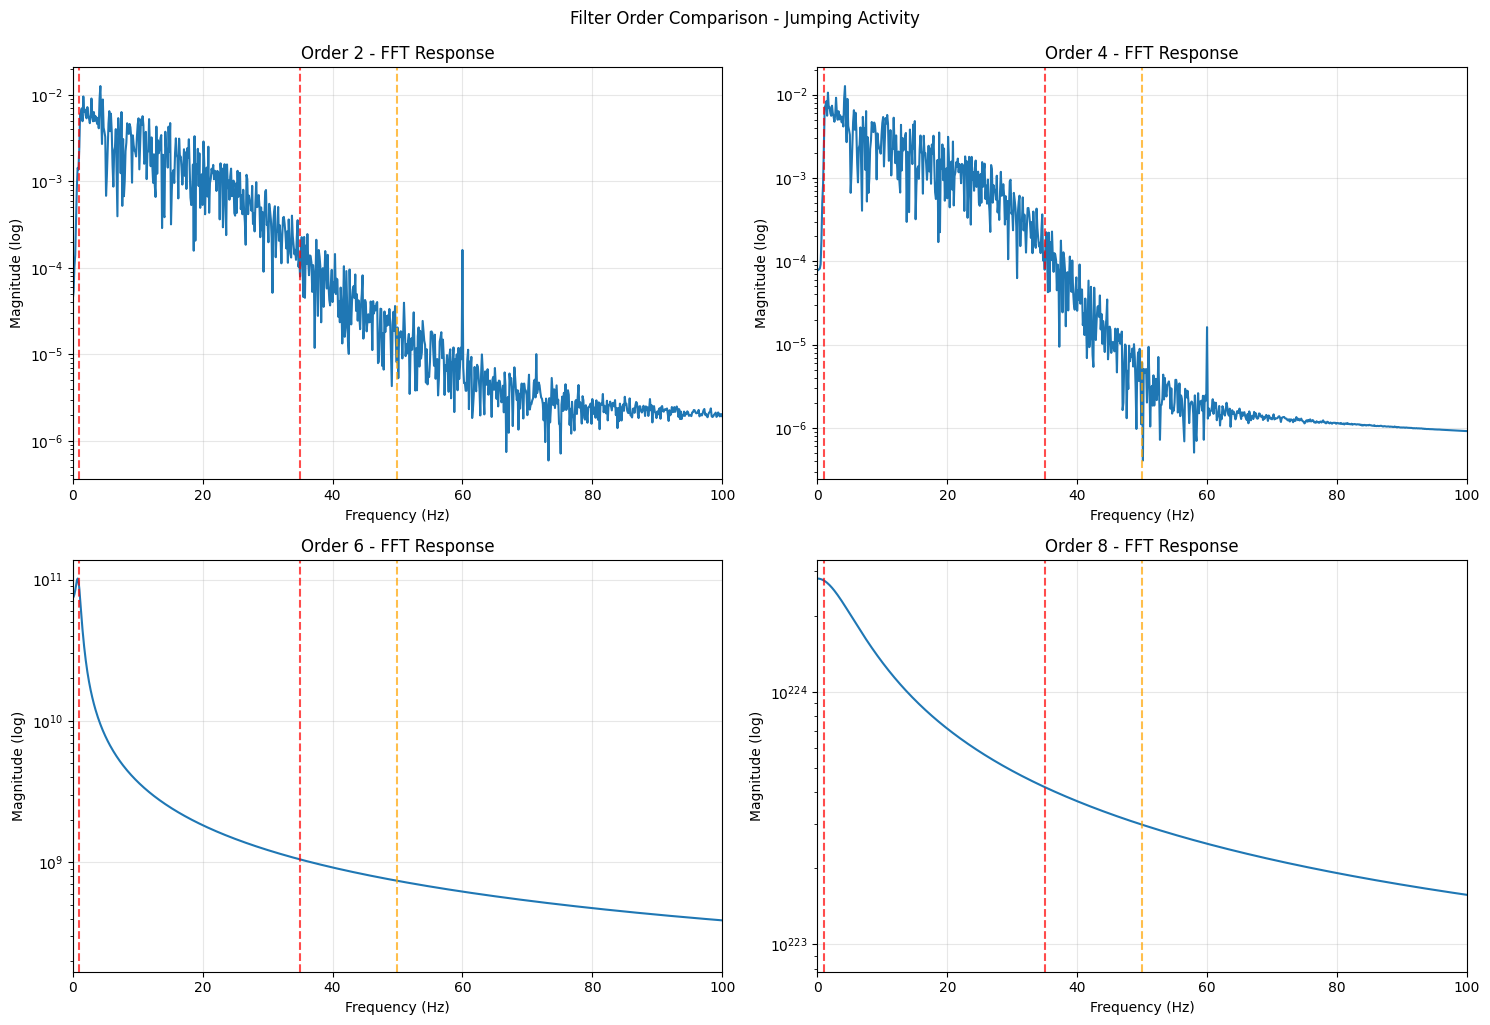

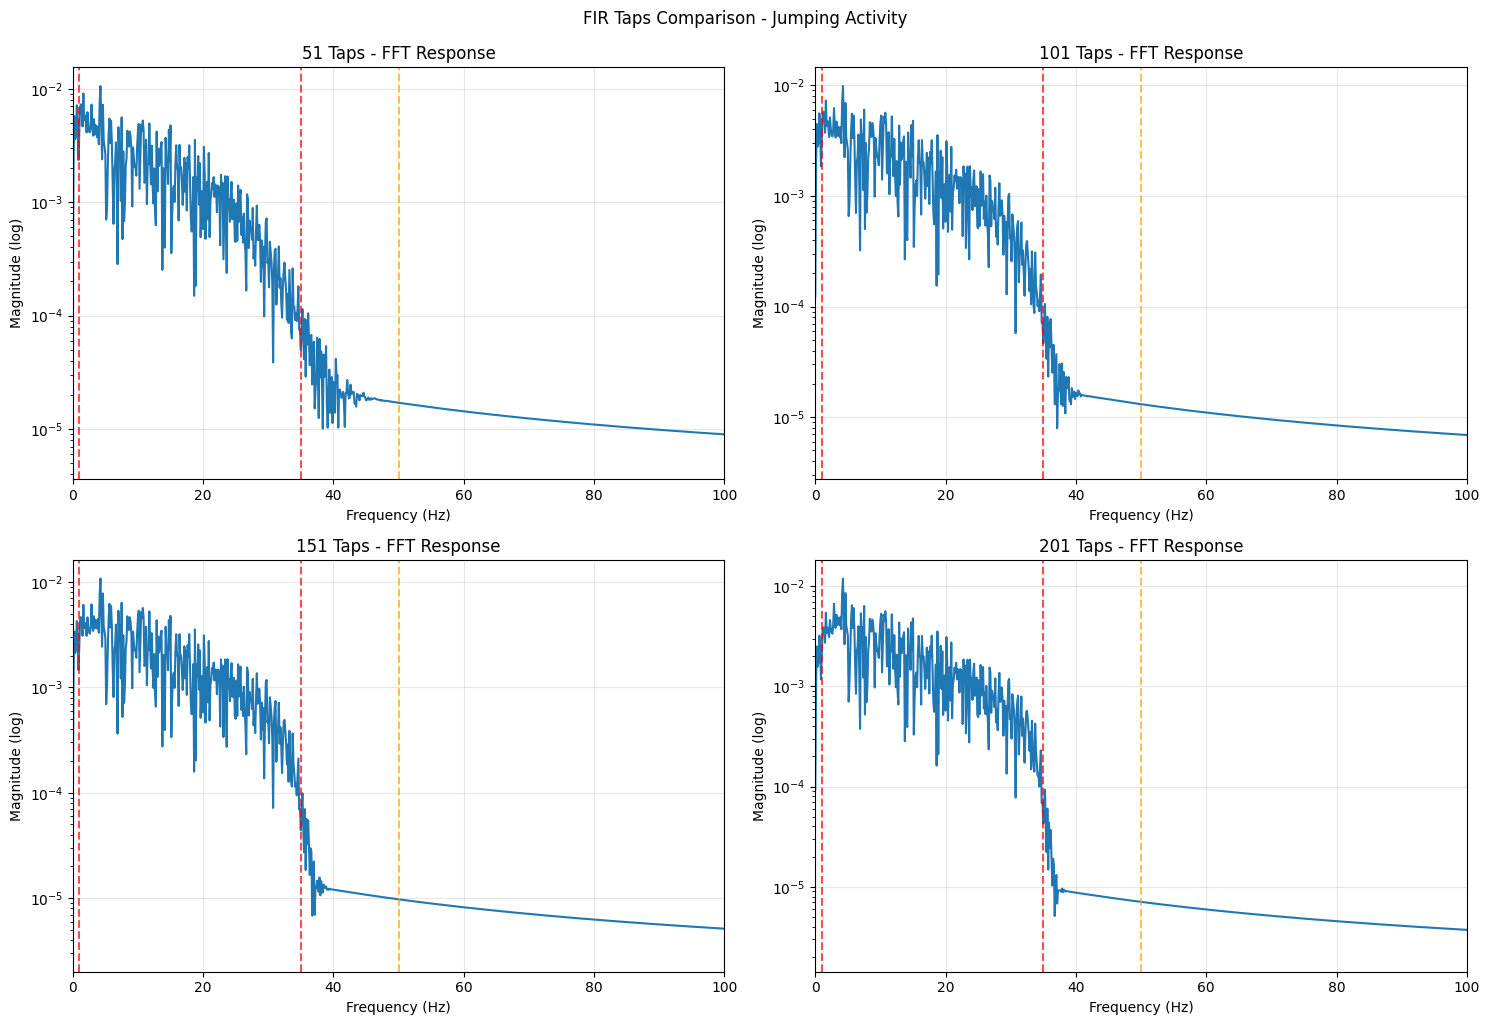


Performance Summary:
          File Activity IIR_SNR_dB FIR_SNR_dB IIR_Correlation FIR_Correlation  IIR_Order  FIR_Taps Complexity_Ratio
test07_00s.dat Standing      16.34      16.42           0.976           0.985          4       201            22.3x
test16_00w.dat  Walking      15.73      12.67           0.981           0.976          4       201            22.3x
test26_45j.dat  Jumping      10.11       8.92           0.939           0.943          4       201            22.3x

test07_00s.dat - Standing:
  Ch1: IIR SNR=10.4dB, FIR SNR=13.7dB
  Ch2: IIR SNR=21.6dB, FIR SNR=20.0dB
  Ch3: IIR SNR=22.6dB, FIR SNR=20.3dB
  Ch4: IIR SNR=10.8dB, FIR SNR=11.6dB

test16_00w.dat - Walking:
  Ch1: IIR SNR=11.8dB, FIR SNR=9.8dB
  Ch2: IIR SNR=20.5dB, FIR SNR=14.6dB
  Ch3: IIR SNR=18.6dB, FIR SNR=16.1dB
  Ch4: IIR SNR=12.1dB, FIR SNR=10.2dB

test26_45j.dat - Jumping:
  Ch1: IIR SNR=10.5dB, FIR SNR=9.6dB
  Ch2: IIR SNR=13.1dB, FIR SNR=9.7dB
  Ch3: IIR SNR=10.7dB, FIR SNR=9.5dB
  Ch4: IIR SNR=6.2

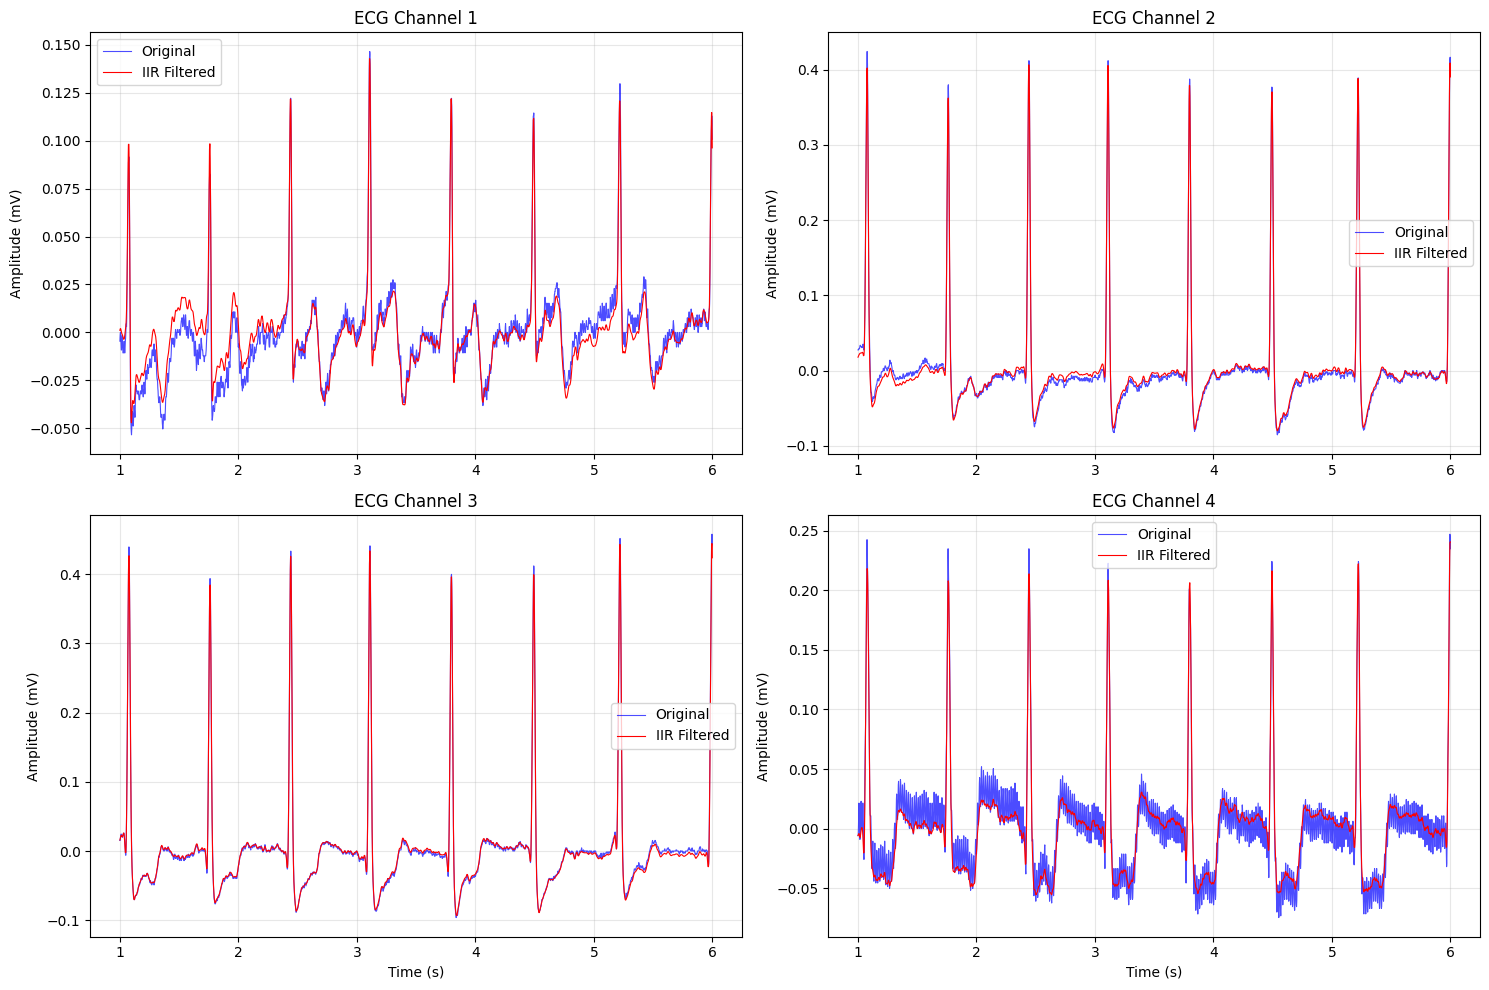

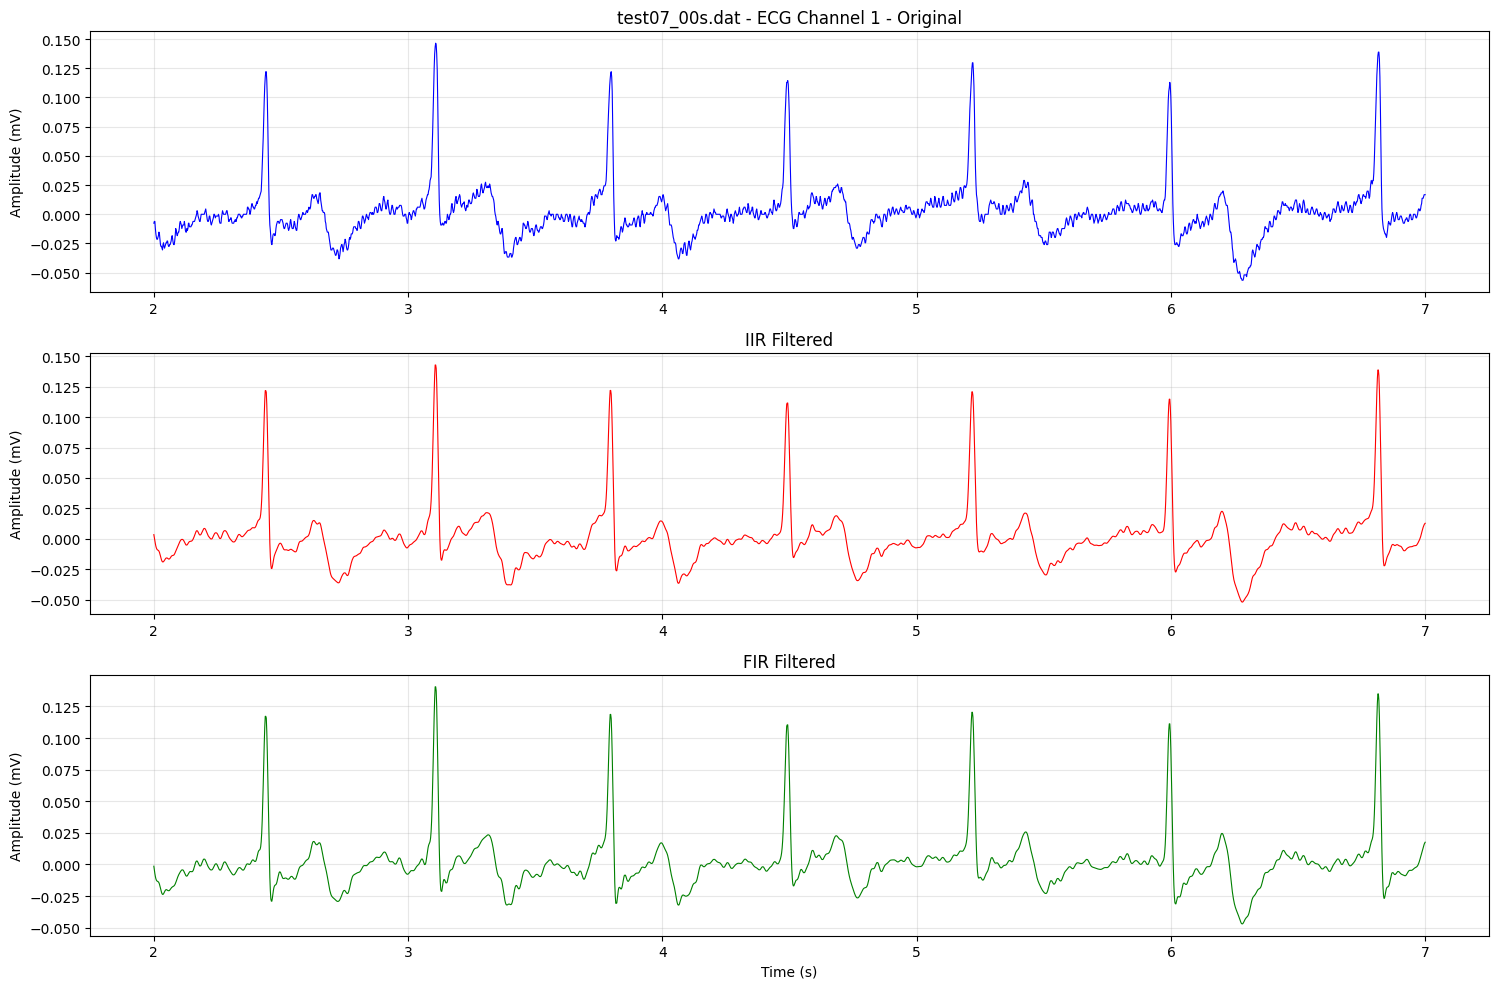


Plotting results for test16_00w.dat...


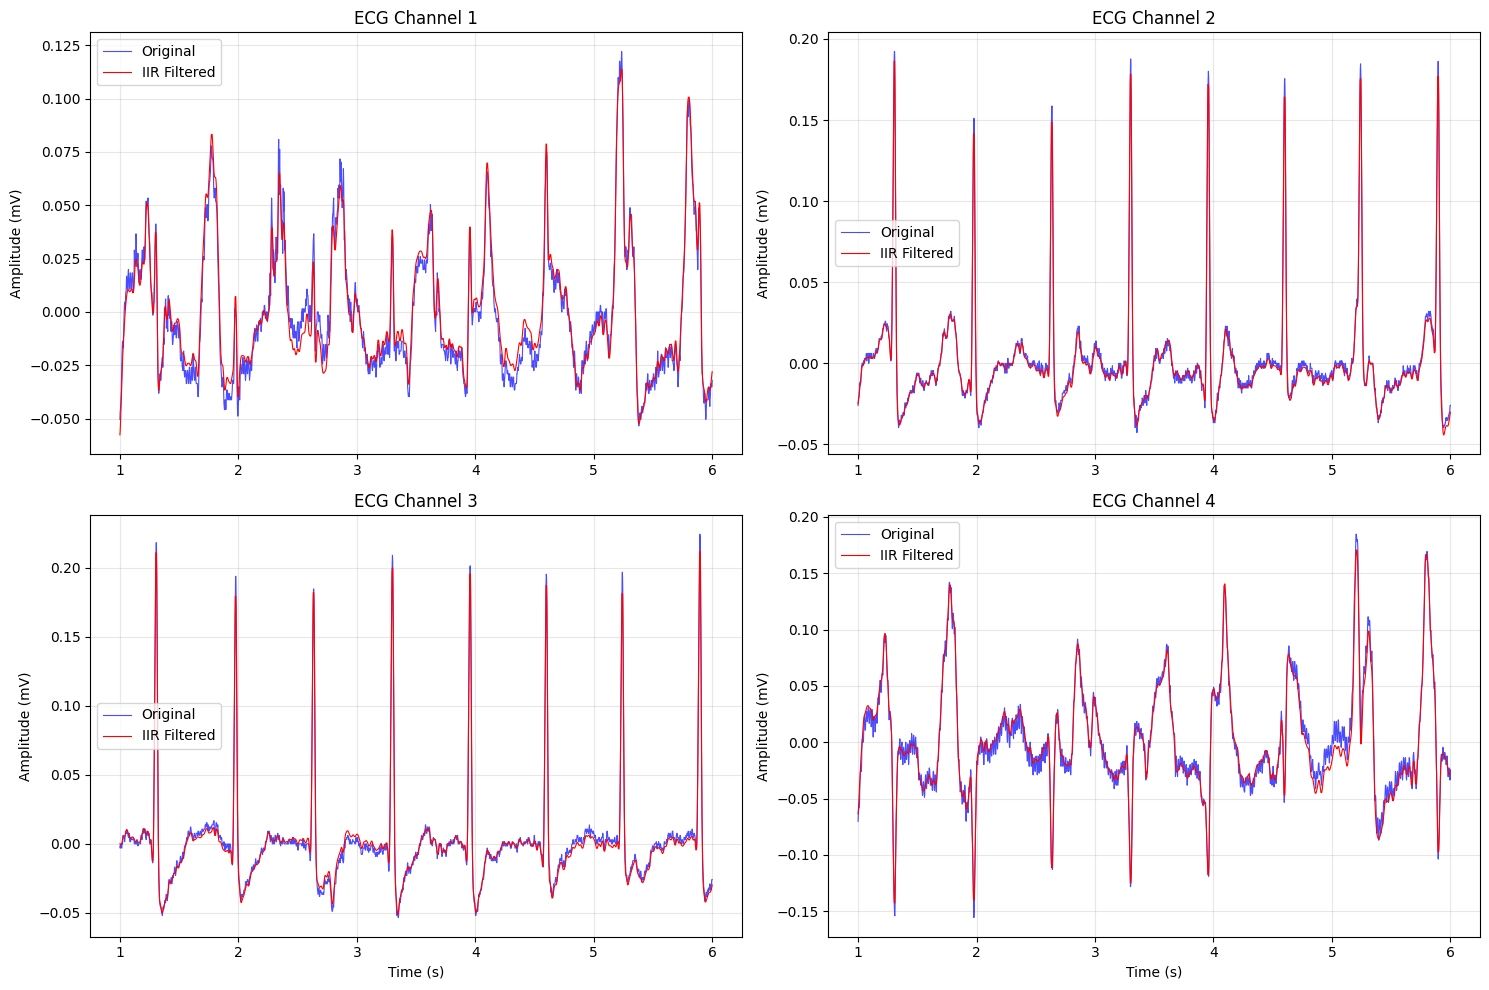

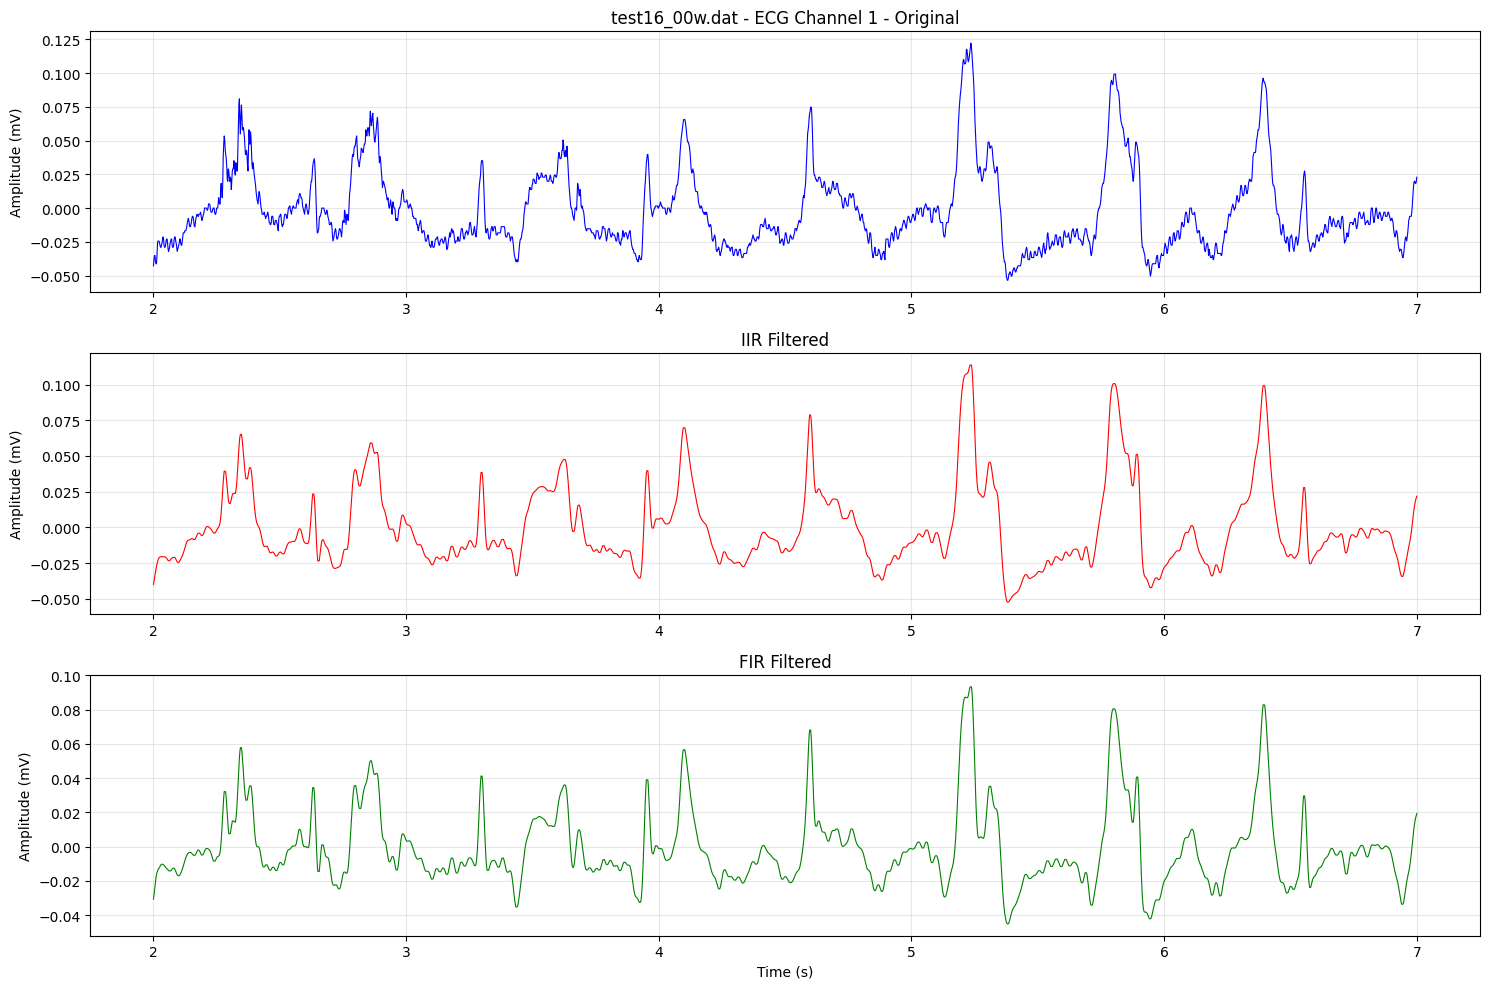


Plotting results for test26_45j.dat...


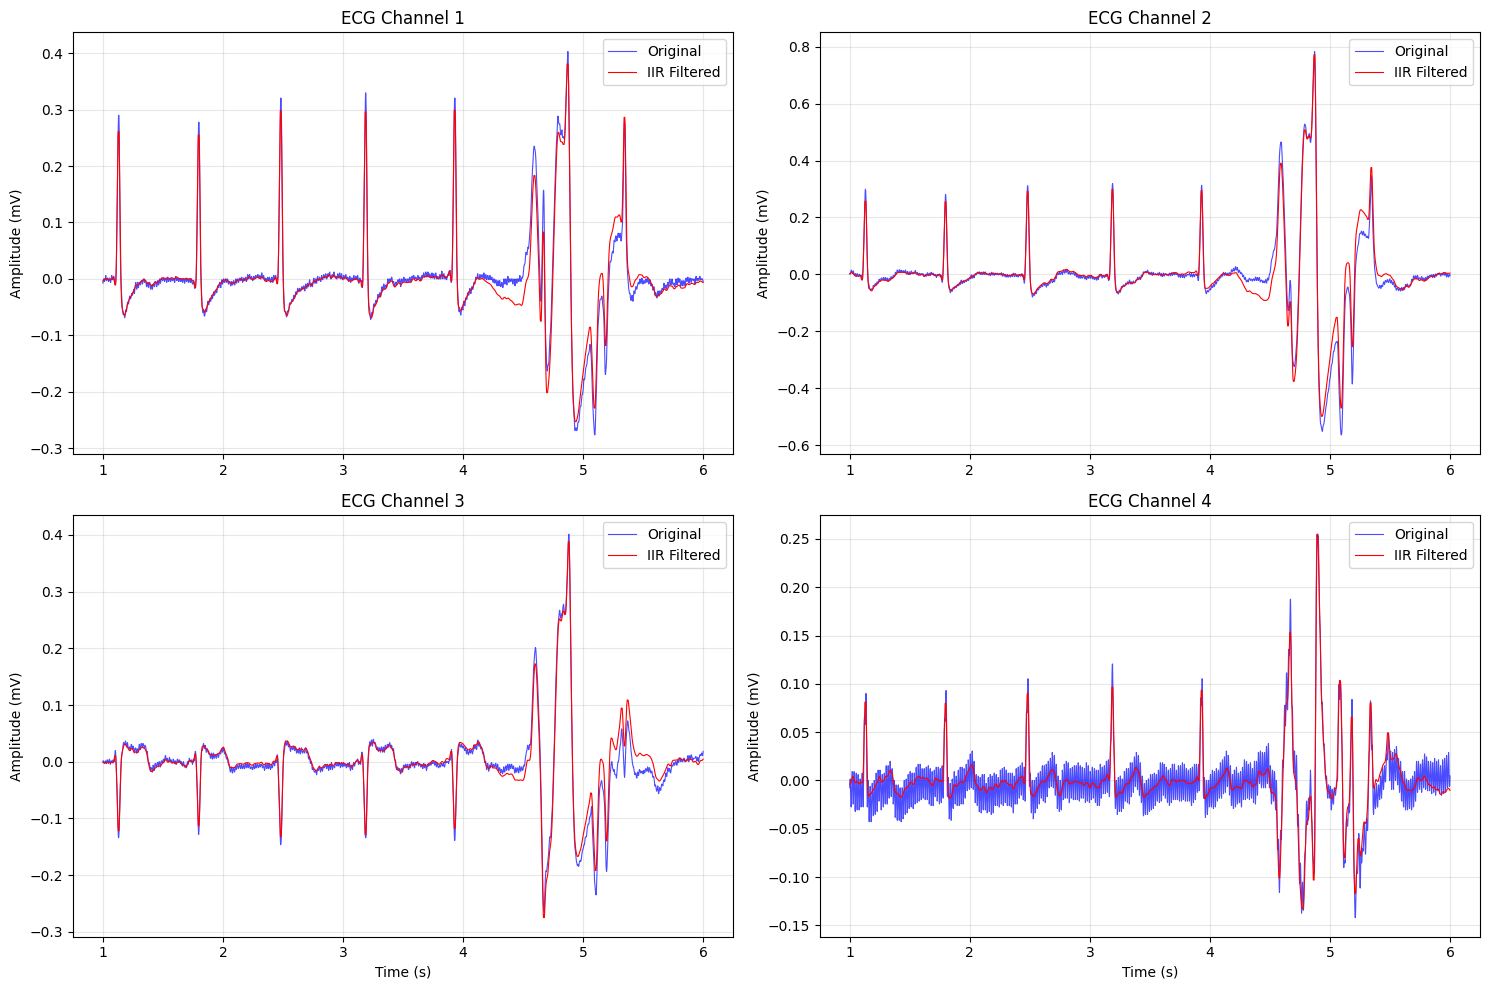

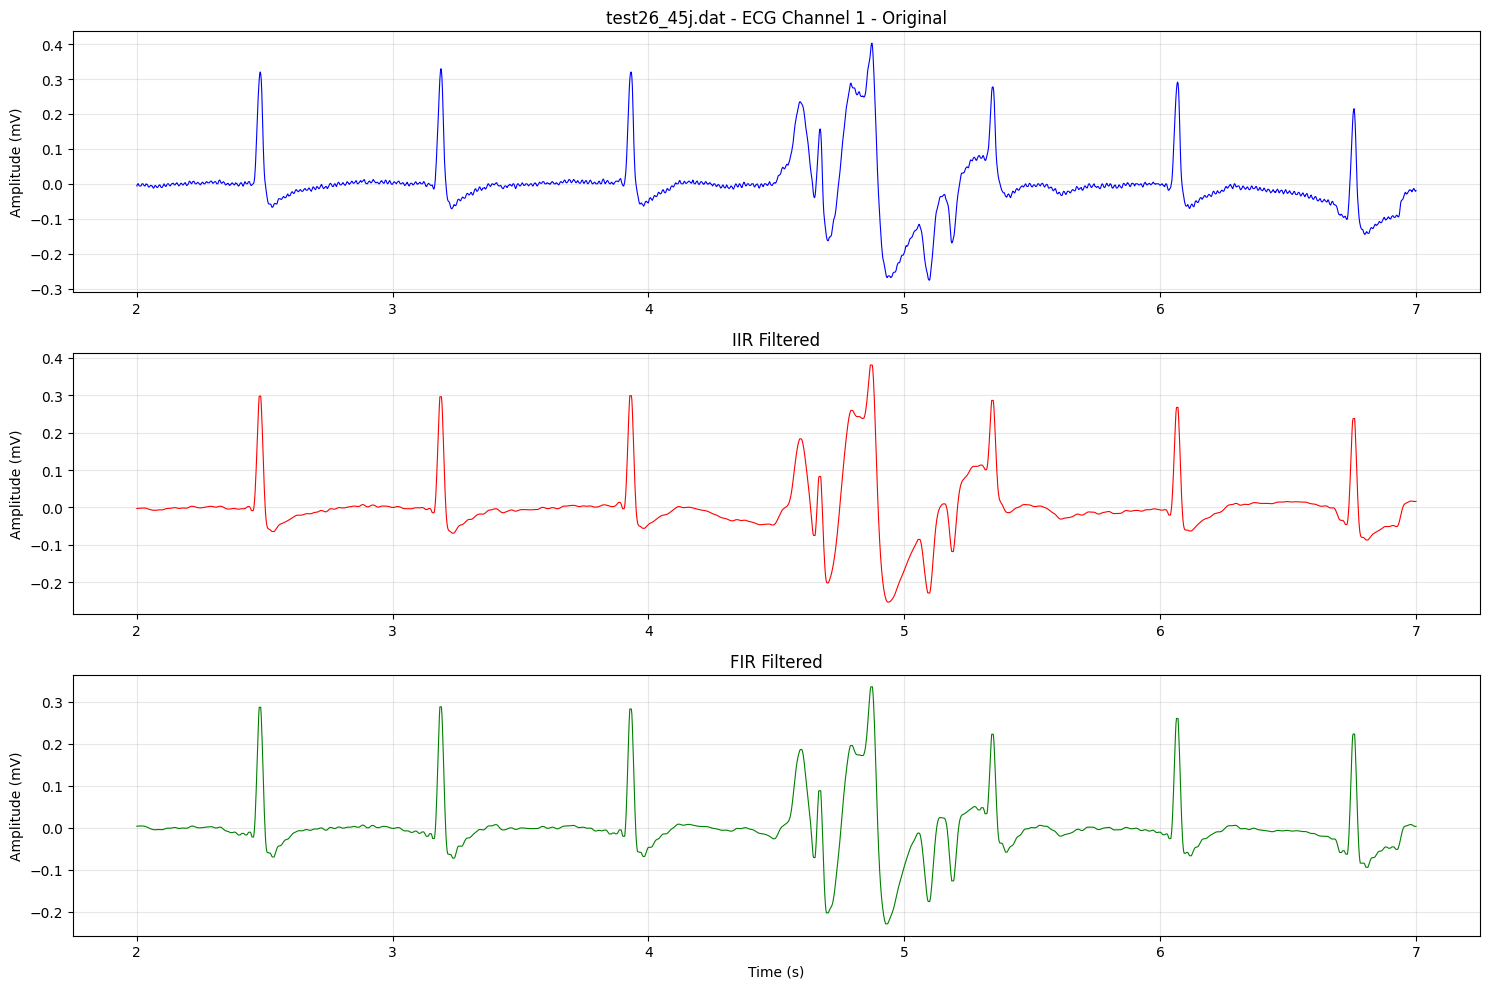


Frequency response for Standing:


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18424\2613899173.py:392: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_iir, 20 * np.log10(abs(h_iir)), 'r-', linewidth=2,


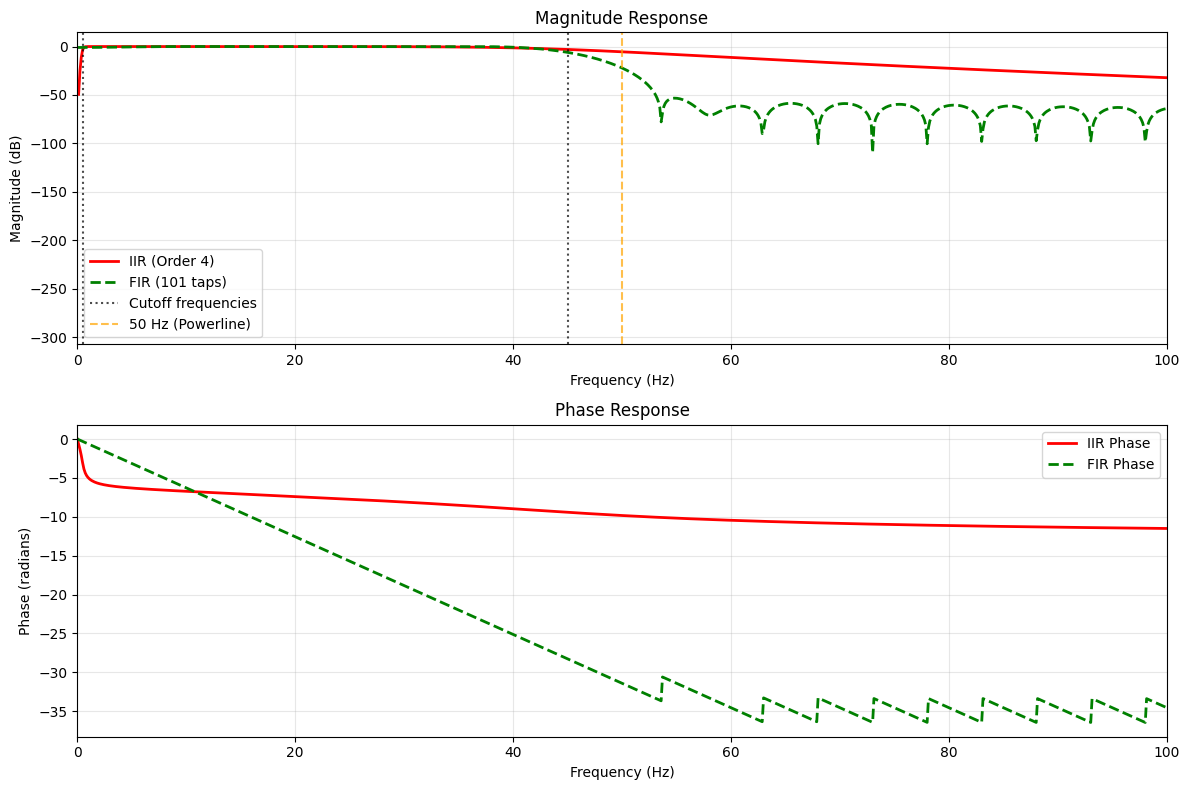


Frequency response for Walking:


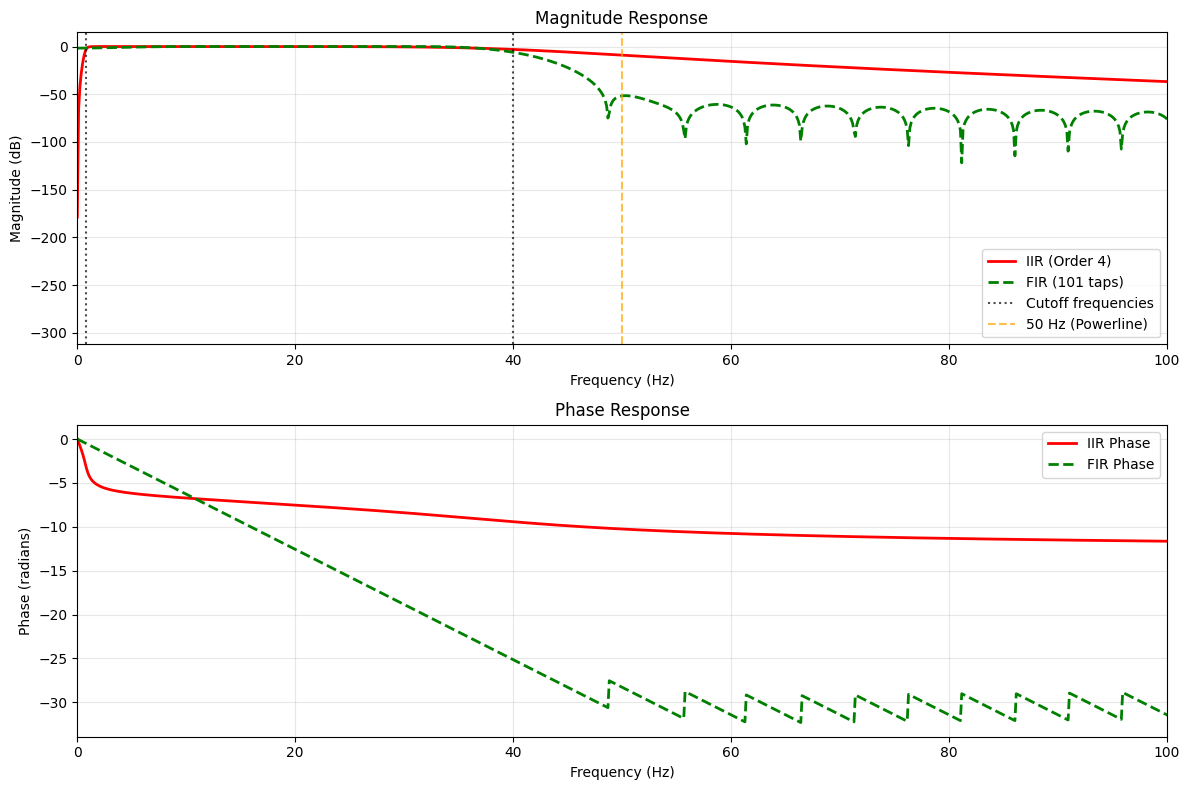


Frequency response for Jumping:


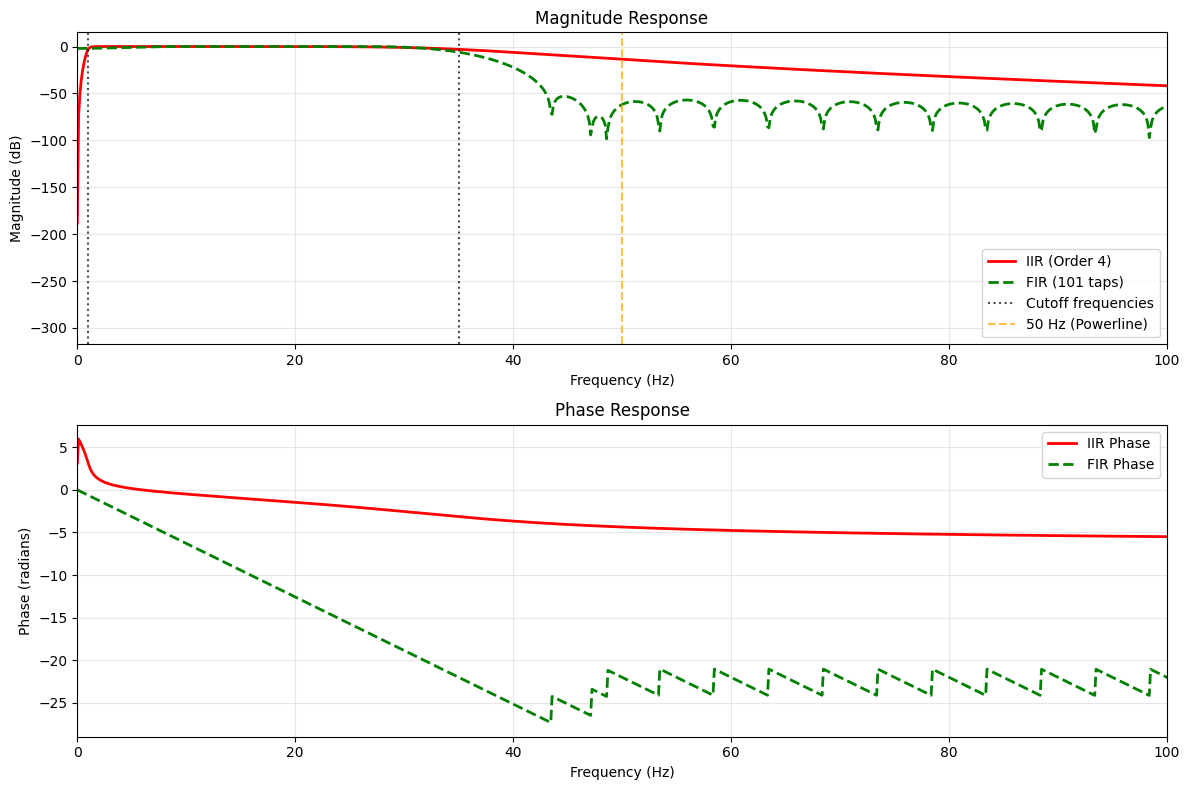

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, firwin, lfilter, freqz, iirnotch
import pandas as pd
import os
class ECGProcessor:

    def __init__(self, fs=500, gain=100, resolution_bits=16, data_path="./"):
        self.fs = fs
        self.nyquist = fs / 2
        self.gain = gain
        self.resolution_bits = resolution_bits
        self.data_path = data_path
        
        self.filter_configs = {
            's': {'name': 'Standing', 'lowcut': 0.5, 'highcut': 45, 'order': 4, 'notch_q': 20, 'median_kernel': 3},
            'w': {'name': 'Walking', 'lowcut': 0.8, 'highcut': 40, 'order': 4, 'notch_q': 25, 'median_kernel': 5},
            'j': {'name': 'Jumping', 'lowcut': 1.0, 'highcut': 35, 'order': 4, 'notch_q': 30, 'median_kernel': 7}
        }
    
    def set_data_path(self, path):
        self.data_path = path
        print(f"Data path set to: {self.data_path}")
    
    def read_dat_file(self, filename):
        full_path = os.path.join(self.data_path, filename)
        
        try:
            with open(full_path, 'rb') as f:
                data_raw = np.frombuffer(f.read(), dtype=np.int16)
            if len(data_raw) % 4 != 0:
                data_raw = data_raw[:-(len(data_raw) % 4)]
            data_reshaped = data_raw.reshape(-1, 4)
            adc_range_v = 10.0
            voltage_per_bit = adc_range_v / (2**self.resolution_bits)
            data_mv = (data_reshaped * voltage_per_bit / self.gain) * 1000
            
            print(f"Loaded {filename}: {data_reshaped.shape[0]} samples, 4 channels")
            print(f"Duration: {data_reshaped.shape[0]/self.fs:.2f} seconds")
            
            return data_mv
            
        except FileNotFoundError:
            print(f"File {full_path} not found. Generating simulated data.")
            return self.generate_simulated_data(filename)
    
    def generate_simulated_data(self, filename, duration=10):
        samples = int(duration * self.fs)
        t = np.linspace(0, duration, samples)
        activity = 's' 
        filename_lower = filename.lower()
        if 'w' in filename_lower:
            activity = 'w'
        elif 'j' in filename_lower:
            activity = 'j'
        elif 's' in filename_lower:
            activity = 's'
        activity_params = {
            's': {'motion_amp': 0.1, 'noise_amp': 0.05},   # Standing - low noise
            'w': {'motion_amp': 0.3, 'noise_amp': 0.1},    # Walking - medium noise
            'j': {'motion_amp': 0.8, 'noise_amp': 0.2}     # Jumping - high noise
        }
        params = activity_params.get(activity, activity_params['s'])
        
        data = np.zeros((samples, 4))
        
        for channel in range(4):
            ecg_clean = self.generate_clean_ecg(t, hr=70 + channel*2)
            baseline_wander = params['motion_amp'] * np.sin(2*np.pi*0.3*t + channel*np.pi/4)
            muscle_artifact = params['noise_amp'] * np.random.randn(samples)
            electrode_noise = 0.02 * np.random.randn(samples)
            powerline_noise = 0.03 * np.sin(2*np.pi*50*t + np.random.random()*2*np.pi)
            
            data[:, channel] = (ecg_clean + baseline_wander + muscle_artifact + 
                              electrode_noise + powerline_noise)
        
        return data
    
    def generate_clean_ecg(self, t, hr=72):
        ecg = np.zeros_like(t)
        beat_period = 60.0 / hr
        
        for beat_start in np.arange(0, t[-1], beat_period):
            p_center = beat_start + 0.08
            p_mask = np.abs(t - p_center) < 0.04
            if np.any(p_mask):
                ecg[p_mask] += 0.1 * np.exp(-((t[p_mask] - p_center) / 0.02)**2)
            
            q_center = beat_start + 0.16
            q_mask = np.abs(t - q_center) < 0.01
            if np.any(q_mask):
                ecg[q_mask] -= 0.1 * np.exp(-((t[q_mask] - q_center) / 0.005)**2)
            
            r_center = beat_start + 0.18
            r_mask = np.abs(t - r_center) < 0.02
            if np.any(r_mask):
                ecg[r_mask] += 1.2 * np.exp(-((t[r_mask] - r_center) / 0.01)**2)
            
            s_center = beat_start + 0.20
            s_mask = np.abs(t - s_center) < 0.01
            if np.any(s_mask):
                ecg[s_mask] -= 0.2 * np.exp(-((t[s_mask] - s_center) / 0.005)**2)
            
            t_center = beat_start + 0.35
            t_mask = np.abs(t - t_center) < 0.1
            if np.any(t_mask):
                ecg[t_mask] += 0.3 * np.exp(-((t[t_mask] - t_center) / 0.05)**2)
        
        return ecg
    
    def plot_fft(self, signal, title="FFT of ECG Signal"):
        n = len(signal)
        freqs = np.fft.rfftfreq(n, d=1/self.fs)
        fft_magnitude = np.abs(np.fft.rfft(signal)) / n
        
        plt.figure(figsize=(12, 6))
        plt.semilogy(freqs, fft_magnitude)
        plt.title(title)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (log scale)")
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 100) 
        plt.axvline(0.5, color='red', linestyle='--', alpha=0.7, label='0.5 Hz (baseline)')
        plt.axvline(50, color='orange', linestyle='--', alpha=0.7, label='50 Hz (powerline)')
        plt.axvline(40, color='green', linestyle='--', alpha=0.7, label='40 Hz (ECG cutoff)')
        plt.legend()
        plt.show()

    def plot_filter_order_comparison(self, data, config, channel=0):
        orders = [2, 4, 6, 8]
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        n = len(data)
        freqs = np.fft.rfftfreq(n, d=1/self.fs)
        
        for i, order in enumerate(orders):
            b, a = self.design_butterworth_filter(config['lowcut'], config['highcut'], order)
            filtered = filtfilt(b, a, data, axis=0)
            fft_magnitude = np.abs(np.fft.rfft(filtered[:, channel])) / n
            
            axes[i].semilogy(freqs, fft_magnitude)
            axes[i].set_title(f'Order {order} - FFT Response')
            axes[i].set_xlabel('Frequency (Hz)')
            axes[i].set_ylabel('Magnitude (log)')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(0, 100)
            axes[i].axvline(config['lowcut'], color='red', linestyle='--', alpha=0.7)
            axes[i].axvline(config['highcut'], color='red', linestyle='--', alpha=0.7)
            axes[i].axvline(50, color='orange', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.suptitle(f'Filter Order Comparison - {config["name"]} Activity', y=1.02)
        plt.show()

    def plot_fir_taps_comparison(self, data, config, channel=0):
        tap_counts = [51, 101, 151, 201]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        n = len(data)
        freqs = np.fft.rfftfreq(n, d=1/self.fs)
        
        for i, taps in enumerate(tap_counts):
            b = firwin(taps, [config['lowcut'], config['highcut']], fs=self.fs, pass_zero=False, window='hamming')
            filtered = filtfilt(b, [1], data, axis=0)
            fft_magnitude = np.abs(np.fft.rfft(filtered[:, channel])) / n
            
            axes[i].semilogy(freqs, fft_magnitude)
            axes[i].set_title(f'{taps} Taps - FFT Response')
            axes[i].set_xlabel('Frequency (Hz)')
            axes[i].set_ylabel('Magnitude (log)')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(0, 100)
            axes[i].axvline(config['lowcut'], color='red', linestyle='--', alpha=0.7)
            axes[i].axvline(config['highcut'], color='red', linestyle='--', alpha=0.7)
            axes[i].axvline(50, color='orange', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.suptitle(f'FIR Taps Comparison - {config["name"]} Activity', y=1.02)
        plt.show()

    def design_butterworth_filter(self, lowcut, highcut, order=4):
        low = lowcut / self.nyquist
        high = highcut / self.nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a
    
    def design_fir_filter(self, lowcut, highcut, numtaps=101, window='hamming'):
        b = firwin(numtaps, [lowcut, highcut], fs=self.fs, pass_zero=False, window=window)
        return b, [1]
    
    def apply_notch_filter(self, data, freq=50, q=30):
        b, a = iirnotch(freq, q, fs=self.fs)
        return filtfilt(b, a, data, axis=0)
    
    def apply_median_filter(self, data, kernel_size=5):
        filtered_data = np.zeros_like(data)
        for ch in range(data.shape[1]):
            filtered_data[:, ch] = signal.medfilt(data[:, ch], kernel_size)
        return filtered_data
    
    def filter_ecg_iir(self, data, lowcut, highcut, order=4, notch_q=30, median_kernel=5):
        b, a = self.design_butterworth_filter(lowcut, highcut, order)
        filtered = filtfilt(b, a, data, axis=0)
        filtered = self.apply_notch_filter(filtered, freq=50, q=notch_q)
        if median_kernel > 1:
            filtered = self.apply_median_filter(filtered, median_kernel)
        
        return filtered
    
    def filter_ecg_fir(self, data, lowcut, highcut, numtaps=101, window='hamming', notch_q=30, median_kernel=5):
        b, a = self.design_fir_filter(lowcut, highcut, numtaps, window)
        filtered = filtfilt(b, a, data, axis=0)
        filtered = self.apply_notch_filter(filtered, freq=50, q=notch_q)
        if median_kernel > 1:
            filtered = self.apply_median_filter(filtered, median_kernel)
        
        return filtered
    
    def calculate_performance_metrics(self, original, filtered):
        metrics = {}
        
        for ch in range(original.shape[1]):
            orig = original[:, ch]
            filt = filtered[:, ch]
            
            orig_power = np.var(orig)
            noise_power = np.var(orig - filt)
            snr_improvement = 10 * np.log10(orig_power / (noise_power + 1e-10))

            rmse = np.sqrt(np.mean((orig - filt) ** 2))

            correlation = np.corrcoef(orig, filt)[0, 1] if np.std(orig) > 0 and np.std(filt) > 0 else 0
            prd = 100 * rmse / np.sqrt(np.mean(orig ** 2)) if np.mean(orig ** 2) > 0 else 0
            
            metrics[f'ECG_{ch+1}'] = {
                'SNR_improvement_dB': snr_improvement,
                'RMSE': rmse,
                'Correlation': correlation,
                'PRD_%': prd
            }
        
        return metrics
    
    def process_signal_file(self, filename):
        data = self.read_dat_file(filename)
        activity_type = 's' 
        filename_lower = filename.lower()
        if 'w' in filename_lower:
            activity_type = 'w'
        elif 'j' in filename_lower:
            activity_type = 'j'
        elif 's' in filename_lower:
            activity_type = 's'
            
        config = self.filter_configs.get(activity_type, self.filter_configs['s'])
        
        print(f"\nProcessing {filename} ({config['name']})")
        filtered_iir = self.filter_ecg_iir(
            data, config['lowcut'], config['highcut'], 
            config['order'], config['notch_q'], config['median_kernel']
        )
        transition_width = min(config['lowcut'], self.fs/2 - config['highcut']) / 2
        numtaps = max(51, int(3 * self.fs / transition_width))
        if numtaps % 2 == 0:
            numtaps += 1
        numtaps = min(numtaps, 201)
        filtered_fir = self.filter_ecg_fir(
            data, config['lowcut'], config['highcut'],
            numtaps, 'hamming', config['notch_q'], config['median_kernel']
        )
        
        metrics_iir = self.calculate_performance_metrics(data, filtered_iir)
        metrics_fir = self.calculate_performance_metrics(data, filtered_fir)
        
        return {
            'filename': filename,
            'activity_type': activity_type,
            'activity_name': config['name'],
            'original': data,
            'filtered_iir': filtered_iir,
            'filtered_fir': filtered_fir,
            'metrics_iir': metrics_iir,
            'metrics_fir': metrics_fir,
            'config': config,
            'fir_taps': numtaps
        } 
    def process_all_signals(self, signal_files):
        results = {}
        for filename in signal_files:
            try:
                results[filename] = self.process_signal_file(filename)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
        return results
    
    def plot_signal_comparison(self, result, channel=0, time_window=(0, 5)):
        data = result['original']
        filtered_iir = result['filtered_iir'] 
        filtered_fir = result['filtered_fir']
        
        t = np.linspace(0, len(data)/self.fs, len(data))
        start_idx = int(time_window[0] * self.fs)
        end_idx = int(time_window[1] * self.fs)
        t_window = t[start_idx:end_idx]
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        axes[0].plot(t_window, data[start_idx:end_idx, channel], 'b-', linewidth=0.8)
        axes[0].set_title(f'{result["filename"]} - ECG Channel {channel+1} - Original')
        axes[0].set_ylabel('Amplitude (mV)')
        axes[0].grid(True, alpha=0.3)
        axes[1].plot(t_window, filtered_iir[start_idx:end_idx, channel], 'r-', linewidth=0.8)
        axes[1].set_title('IIR Filtered')
        axes[1].set_ylabel('Amplitude (mV)')
        axes[1].grid(True, alpha=0.3)
        axes[2].plot(t_window, filtered_fir[start_idx:end_idx, channel], 'g-', linewidth=0.8)
        axes[2].set_title('FIR Filtered')
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Amplitude (mV)')
        axes[2].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_all_channels(self, result, time_window=(0, 5)):
        data = result['original']
        filtered_iir = result['filtered_iir']
        t = np.linspace(0, len(data)/self.fs, len(data))
        start_idx = int(time_window[0] * self.fs)
        end_idx = int(time_window[1] * self.fs)
        t_window = t[start_idx:end_idx]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for ch in range(4):
            axes[ch].plot(t_window, data[start_idx:end_idx, ch], 'b-', alpha=0.7, 
                         linewidth=0.8, label='Original')
            axes[ch].plot(t_window, filtered_iir[start_idx:end_idx, ch], 'r-', 
                         linewidth=0.8, label='IIR Filtered')
            axes[ch].set_title(f'ECG Channel {ch+1}')
            axes[ch].set_ylabel('Amplitude (mV)')
            axes[ch].grid(True, alpha=0.3)
            axes[ch].legend()
            if ch >= 2:
                axes[ch].set_xlabel('Time (s)')
        
        plt.tight_layout()
        plt.show()
    
    def plot_frequency_response(self, config, fir_taps=101):
        b_iir, a_iir = self.design_butterworth_filter(config['lowcut'], config['highcut'], config['order'])
        w_iir, h_iir = freqz(b_iir, a_iir, fs=self.fs, worN=2048)
        b_fir, a_fir = self.design_fir_filter(config['lowcut'], config['highcut'], fir_taps, 'hamming')
        w_fir, h_fir = freqz(b_fir, a_fir, fs=self.fs, worN=2048)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(w_iir, 20 * np.log10(abs(h_iir)), 'r-', linewidth=2, 
                label=f'IIR (Order {config["order"]})')
        plt.plot(w_fir, 20 * np.log10(abs(h_fir)), 'g--', linewidth=2, 
                label=f'FIR ({fir_taps} taps)')
        plt.axvline(config['lowcut'], color='k', linestyle=':', alpha=0.7, label='Cutoff frequencies')
        plt.axvline(config['highcut'], color='k', linestyle=':', alpha=0.7)
        plt.axvline(50, color='orange', linestyle='--', alpha=0.7, label='50 Hz (Powerline)')
        plt.title('Magnitude Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 100)
        plt.subplot(2, 1, 2)
        plt.plot(w_iir, np.unwrap(np.angle(h_iir)), 'r-', linewidth=2, label='IIR Phase')
        plt.plot(w_fir, np.unwrap(np.angle(h_fir)), 'g--', linewidth=2, label='FIR Phase') 
        plt.title('Phase Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (radians)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    def create_summary_table(self, results):
        summary_data = []
        
        for filename, result in results.items():
            iir_metrics = result['metrics_iir']
            fir_metrics = result['metrics_fir']
            avg_iir_snr = np.mean([m['SNR_improvement_dB'] for m in iir_metrics.values()])
            avg_fir_snr = np.mean([m['SNR_improvement_dB'] for m in fir_metrics.values()])
            avg_iir_corr = np.mean([m['Correlation'] for m in iir_metrics.values()])
            avg_fir_corr = np.mean([m['Correlation'] for m in fir_metrics.values()])
            iir_ops = 2 * result['config']['order'] + 1
            fir_ops = result['fir_taps']
            complexity_ratio = fir_ops / iir_ops
            
            summary_data.append({
                'File': filename,
                'Activity': result['activity_name'],
                'IIR_SNR_dB': f"{avg_iir_snr:.2f}",
                'FIR_SNR_dB': f"{avg_fir_snr:.2f}",
                'IIR_Correlation': f"{avg_iir_corr:.3f}",
                'FIR_Correlation': f"{avg_fir_corr:.3f}",
                'IIR_Order': result['config']['order'],
                'FIR_Taps': result['fir_taps'],
                'Complexity_Ratio': f"{complexity_ratio:.1f}x"
            })
        
        return pd.DataFrame(summary_data)


def run_ecg_analysis():
    
    print("ECG Signal Processing Tool")
    print("=" * 50)
    data_path = input("Enter the path to your data files (or press Enter for current directory): ").strip()
    
    data_path = data_path.strip('"').strip("'")
    
    if not data_path or not os.path.exists(data_path):
        data_path = "./"
        print(f"Using current directory: {os.path.abspath(data_path)}")
    processor = ECGProcessor(fs=500, data_path=data_path)

    print(f"\nCurrent data path: {os.path.abspath(processor.data_path)}")
    try:
        available_files = [f for f in os.listdir(processor.data_path) if f.endswith('.dat')]
        if available_files:
            print(f"Available .dat files: {available_files}")
        else:
            print("No .dat files found in the directory.")
    except:
        print("Could not list files in the directory.")
    

    signal_files = ['test_007s.dat', 'test16w.dat', 'test_26j.dat']
    
    if available_files:
        actual_files = []
        for pref in ['s', 'w', 'j']:
            matching = [f for f in available_files if pref in f.lower()]
            if matching:
                actual_files.append(matching[0])
        if actual_files:
            signal_files = actual_files
    
    print(f"\nDefault files to process: {signal_files}")
    custom_files = input("Enter file names separated by commas (or press Enter to use defaults): ").strip()
    
    if custom_files:
        signal_files = [f.strip().strip('"').strip("'") for f in custom_files.split(',')]
        signal_files = [f if f.endswith('.dat') else f + '.dat' for f in signal_files]
    
    print(f"\nFiles to process: {signal_files}")
    
    results = processor.process_all_signals(signal_files)
    
    if not results:
        print("No files were successfully processed.")
        return

    print("\n" + "="*50)
    print("FFT ANALYSIS")
    print("="*50)
    first_filename = list(results.keys())[0]
    first_result = results[first_filename]
    processor.plot_fft(first_result['original'][:, 0], f"Original ECG - {first_filename} - Channel 1")
    processor.plot_fft(first_result['filtered_iir'][:, 0], f"IIR Filtered ECG - {first_filename} - Channel 1")
    processor.plot_fft(first_result['filtered_fir'][:, 0], f"FIR Filtered ECG - {first_filename} - Channel 1")
    
    for filename, result in results.items():
        print(f"\nAnalyzing filter parameters for {filename}...")
        processor.plot_filter_order_comparison(result['original'], result['config'], channel=0)
        processor.plot_fir_taps_comparison(result['original'], result['config'], channel=0)

    print("\nPerformance Summary:")
    summary_df = processor.create_summary_table(results)
    if not summary_df.empty:
        print(summary_df.to_string(index=False))
    else:
        print("No summary data available.")
    
    for filename, result in results.items():
        print(f"\n{filename} - {result['activity_name']}:")
        for ch in range(4):
            iir_m = result['metrics_iir'][f'ECG_{ch+1}']
            fir_m = result['metrics_fir'][f'ECG_{ch+1}']
            print(f"  Ch{ch+1}: IIR SNR={iir_m['SNR_improvement_dB']:.1f}dB, "
                  f"FIR SNR={fir_m['SNR_improvement_dB']:.1f}dB")
    
    show_plots = input("\nShow additional signal plots? (y/n): ").lower().startswith('y')
    
    if show_plots:
        for filename, result in results.items():
            print(f"\nPlotting results for {filename}...")
            processor.plot_all_channels(result, time_window=(1, 6))
            processor.plot_signal_comparison(result, channel=0, time_window=(2, 7))
        
        for activity_type, config in processor.filter_configs.items():
            print(f"\nFrequency response for {config['name']}:")
            processor.plot_frequency_response(config, fir_taps=101)


def simple_demo():
    print("Running simple ECG processing demo...")
    processor = ECGProcessor(fs=500, data_path="./")
    signal_files = ['test_s.dat', 'test_w.dat', 'test_j.dat']
    print("Processing with simulated data...")
    results = processor.process_all_signals(signal_files)
    summary_df = processor.create_summary_table(results)
    print("\nSummary:")
    print(summary_df.to_string(index=False))
    if results:
        first_result = list(results.values())[0]
        processor.plot_signal_comparison(first_result, channel=0, time_window=(1, 5))
    
    return results

if __name__ == "__main__":
    mode = input("Choose mode: (1) Interactive analysis (2) Simple demo: ").strip()
    
    if mode == "2":
        simple_demo()
    else:
        run_ecg_analysis()

In [30]:
print(np.arange(1,10,2))

[1 3 5 7 9]
